# Gerardo de Miguel González

**::GMG::** The aim of this notebook is to find a basic workflow for doing machine learning classification of an imbalanced dataset using best practices taken from other people's examples.

# Binary Classification Proof of Concept

## References

**::GMG::** These ones:

  - [STHDA](http://www.sthda.com/english/articles/36-classification-methods-essentials/149-penalized-logistic-regression-essentials-in-r-ridge-lasso-and-elastic-net/) Penalized Logistic Regression Essentials in R: Ridge, Lasso and Elastic Net by kassambara -- 11/03/2018 from  [Articles](http://www.sthda.com/english/articles/36-classification-methods-essentials/) - Classification Methods Essentials
  - [Stanford](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html#log) Glmnet Vignette: Logistic Regression by [Trevor Hastie](https://web.stanford.edu/~hastie/) and Junyang Qian, Stanford June 26, 2014
  - [Lab Notebook](http://homepages.uc.edu/~lis6/Teaching/DM18Spring/Lab/lab5_logit.html) in [Data Mining I (BANA7046) 2018 Spring](http://homepages.uc.edu/~lis6/DM-18Spring.html) by [Shaobo Li](http://homepages.uc.edu/~lis6/), see [Variable Selection section](http://homepages.uc.edu/~lis6/Teaching/DM18Spring/Lab/lab5_logit.html#variable-selection).
  
**::NOTE::** The LASSO is not very good at handling variables which show correlation between them and thus can sometimes show very wild behaviors. (From [rstatisticsblog](https://www.rstatisticsblog.com/data-science-in-action/lasso-regression/))

## Libraries

In [1]:
#::GMG::Helper function to install missing libraries before loading them
# https://stackoverflow.com/questions/4090169/elegant-way-to-check-for-missing-packages-and-install-them
using<-function(...) {
    libs<-unlist(list(...))
    req<-unlist(lapply(libs,require,character.only=TRUE))
    need<-libs[req==FALSE]
    if(length(need)>0){ 
        install.packages(need)
        lapply(need,require,character.only=TRUE)
    }
}

In [2]:
#::NOTE::Downsizing to simpler packages
#using('tidyverse','caret','glmnet', 'mlbench')
# ... repr to fix size of graphics within jupyter noteboook  ...
# https://blog.revolutionanalytics.com/2015/09/resizing-plots-in-the-r-kernel-for-jupyter-notebooks.html
# ... [NO] crossval: Generic Functions for Cross Validation ...
#     Contains generic functions for performing cross validation and for computing diagnostic errors ...
# https://cran.r-project.org/web/packages/crossval/
# https://cran.r-project.org/web/packages/crossval/crossval.pdf
# ... plotmo: Plot a Model's Residuals, Response, and Partial Dependence Plots ...
#       Plot model surfaces for a wide variety of models using partial dependence plots and other techniques. 
#       Also plot model residuals and other information on the model.
# https://cran.r-project.org/web/packages/plotmo/index.html
# https://cran.r-project.org/web/packages/plotmo/plotmo.pdf
# ... MLmetrics: Machine Learning Evaluation Metrics
#     A collection of evaluation metrics, including loss, score and utility functions, that measure regression, 
#     classification and ranking performance.
using('repr', 'mlbench', 'caTools', 'glmnet', 'plotmo', 'MLmetrics')

Loading required package: repr
Loading required package: mlbench
Loading required package: caTools
Loading required package: glmnet
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-18

Loading required package: plotmo
Loading required package: Formula
Loading required package: plotrix
Loading required package: TeachingDemos
Loading required package: MLmetrics

Attaching package: ‘MLmetrics’

The following object is masked from ‘package:base’:

    Recall



**::GMG::** `crossval` package first install output here:

```R
Loading required package: mlbench
Loading required package: caTools
Loading required package: glmnet
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-18

Loading required package: crossval
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘crossval’”Installing package into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
Loading required package: crossval
  1. TRUE
```

**::GMG::** `tidyverse` output first install here:

```R
Loading required package: tidyverse
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘tidyverse’”Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2
Loading required package: glmnet
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-18

Installing package into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
also installing the dependencies ‘tinytex’, ‘rmarkdown’, ‘selectr’, ‘broom’, ‘dbplyr’, ‘modelr’, ‘reprex’, ‘rvest’

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.3     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ dplyr   0.8.3
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  2.1.3     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::lift()       masks caret::lift()
✖ purrr::when()       masks foreach::when()
                           
    1. TRUE
``` 

**::GMG::** First installation of plotmo:

```R
Loading required package: plotmo
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘plotmo’”Installing package into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
also installing the dependencies ‘plotrix’, ‘TeachingDemos’

Loading required package: plotmo
Loading required package: Formula
Loading required package: plotrix
Loading required package: TeachingDemos

    1. TRUE

```

## Dataset

In [3]:
#::GMG::There are two versions in mlbench
# https://www.rdocumentation.org/packages/utils/versions/3.6.1/topics/data
#::NOTE::2nd version comes with zero outliers as NAs
utils::data(PimaIndiansDiabetes2)

In [4]:
#::GMG::See first rows
# https://www.rdocumentation.org/packages/utils/versions/3.6.1/topics/head
#::NOTE::Some NAs show up!
utils::head(PimaIndiansDiabetes2)

pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,NA,33.6,0.627,50,pos
1,85,66,29,NA,26.6,0.351,31,neg
8,183,64,NA,NA,23.3,0.672,32,pos
1,89,66,23,94,28.1,0.167,21,neg
0,137,40,35,168,43.1,2.288,33,pos
5,116,74,NA,NA,25.6,0.201,30,neg


## Exploratory Data Analysis

**::GMG::** The goal of this stage of our study is to get to know the data, their flaws and perhaps some clues to improve them.

In [5]:
#::GMG::PimaIndiansDiabetes2 (say, v2) has the outliers from 
#       glucose, pressure, triceps, insulin and mass as NAs
str(PimaIndiansDiabetes2)

'data.frame':	768 obs. of  9 variables:
 $ pregnant: num  6 1 8 1 0 5 3 10 2 8 ...
 $ glucose : num  148 85 183 89 137 116 78 115 197 125 ...
 $ pressure: num  72 66 64 66 40 74 50 NA 70 96 ...
 $ triceps : num  35 29 NA 23 35 NA 32 NA 45 NA ...
 $ insulin : num  NA NA NA 94 168 NA 88 NA 543 NA ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 NA ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : num  50 31 32 21 33 30 26 29 53 54 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 2 1 2 1 2 1 2 1 2 2 ...


In [6]:
#::GMG::NA counts yield the outliers (!)
#::NOTE::Should I standardize some of the features ('glucose', 'pressure', 'triceps', 'insuline', 'mass')?
#::NOTE::Should I do feature engineering on some of the features 
#        (i.e. age, p.e breaking it into intervals with labels)?
summary(PimaIndiansDiabetes2)

    pregnant         glucose         pressure         triceps     
 Min.   : 0.000   Min.   : 44.0   Min.   : 24.00   Min.   : 7.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 64.00   1st Qu.:22.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :29.00  
 Mean   : 3.845   Mean   :121.7   Mean   : 72.41   Mean   :29.15  
 3rd Qu.: 6.000   3rd Qu.:141.0   3rd Qu.: 80.00   3rd Qu.:36.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
                  NA's   :5       NA's   :35       NA's   :227    
    insulin            mass          pedigree           age        diabetes 
 Min.   : 14.00   Min.   :18.20   Min.   :0.0780   Min.   :21.00   neg:500  
 1st Qu.: 76.25   1st Qu.:27.50   1st Qu.:0.2437   1st Qu.:24.00   pos:268  
 Median :125.00   Median :32.30   Median :0.3725   Median :29.00            
 Mean   :155.55   Mean   :32.46   Mean   :0.4719   Mean   :33.24            
 3rd Qu.:190.00   3rd Qu.:36.60   3rd Qu.:0.6262   3rd Qu.:41.00            
 M

In [7]:
#::GMG::Check for missing values ... I know they are marked witn 'NA' in mlbench 2nd dataset
sapply(PimaIndiansDiabetes2, function(x) sum(is.na(x)))

pregnant  glucose pressure  triceps  insulin     mass pedigree      age 
       0        5       35      227      374       11        0        0 
diabetes 
       0

In [8]:
#::GMG::Now I test the imbalance of the dataset
# http://metadatascience.com/2013/07/03/plotting-the-frequency-distribution-using-r/
table(PimaIndiansDiabetes2$diabetes)


neg pos 
500 268 

In [9]:
prop.table(table(PimaIndiansDiabetes2$diabetes))


      neg       pos 
0.6510417 0.3489583 

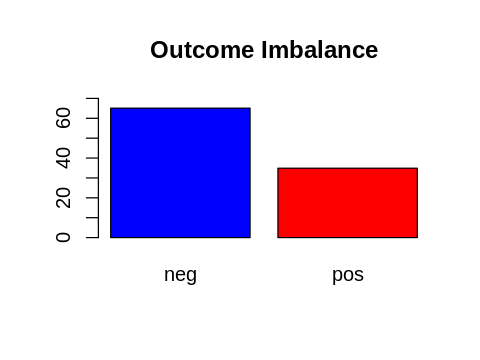

In [10]:
#::GMG::Plot the imbalance
# https://www.statmethods.net/advgraphs/parameters.html
# http://www.programmingr.com/content/positioning-charts-fig-and-fin/
#::NOTE::I don't know how to make the fig smaller and the margins tight (!?)
# https://blog.revolutionanalytics.com/2015/09/resizing-plots-in-the-r-kernel-for-jupyter-notebooks.html
options(repr.plot.width=4, repr.plot.height=3)
barplot(100*prop.table(table(PimaIndiansDiabetes2$diabetes)), 
        col = c('blue', 'red'),
        ylim = c(0,70),
        main = 'Outcome Imbalance')

## Preparing the data

In [11]:
#::GMG:: (STHDA) Load the data and remove NAs
#::NOTE::I've already attached that dataset earlier
# data("PimaIndiansDiabetes2", package = "mlbench")
# https://stat.ethz.ch/R-manual/R-devel/library/stats/html/na.fail.html
# https://www.statmethods.net/input/missingdata.html
pima_clean <- stats::na.omit(PimaIndiansDiabetes2)

In [12]:
#::GMG::Check for missing values ... No NAs after cleaning with na.omit()
sapply(pima_clean, function(x) sum(is.na(x)))

pregnant  glucose pressure  triceps  insulin     mass pedigree      age 
       0        0        0        0        0        0        0        0 
diabetes 
       0

In [13]:
# Inspect the data
# https://dplyr.tidyverse.org/reference/sample.html
#dplyr::sample_n(pima_clean, 3)
#::NOTE::Downsize use of tidyverse to R core functions
# https://www.rdocumentation.org/packages/utils/versions/3.6.1/topics/head
utils::head(pima_clean)

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
4,1,89,66,23,94,28.1,0.167,21,neg
5,0,137,40,35,168,43.1,2.288,33,pos
7,3,78,50,32,88,31.0,0.248,26,pos
9,2,197,70,45,543,30.5,0.158,53,pos
14,1,189,60,23,846,30.1,0.398,59,pos
15,5,166,72,19,175,25.8,0.587,51,pos


In [14]:
#::NOTE::Originally 768 Observations!!
str(pima_clean)

'data.frame':	392 obs. of  9 variables:
 $ pregnant: num  1 0 3 2 1 5 0 1 1 3 ...
 $ glucose : num  89 137 78 197 189 166 118 103 115 126 ...
 $ pressure: num  66 40 50 70 60 72 84 30 70 88 ...
 $ triceps : num  23 35 32 45 23 19 47 38 30 41 ...
 $ insulin : num  94 168 88 543 846 175 230 83 96 235 ...
 $ mass    : num  28.1 43.1 31 30.5 30.1 25.8 45.8 43.3 34.6 39.3 ...
 $ pedigree: num  0.167 2.288 0.248 0.158 0.398 ...
 $ age     : num  21 33 26 53 59 51 31 33 32 27 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 1 2 2 2 2 2 2 1 2 1 ...
 - attr(*, "na.action")= 'omit' Named int  1 2 3 6 8 10 11 12 13 16 ...
  ..- attr(*, "names")= chr  "1" "2" "3" "6" ...


## Stratified Train/Test split

In [15]:
#::NOTE::Make it reproducible
set.seed(123)

In [16]:
# Split the data into training and test set
#::NOTE::STHDA uses caret to do the stratified split and dplyr %>% notation
#        and I think It's a bit of overdoing it ...
# https://topepo.github.io/caret/data-splitting.html
# https://github.com/tidyverse/dplyr
#training_samples <- pima_clean$diabetes %>% 
#  caret::createDataPartition(p = 0.8, list = FALSE)
#::NOTE::... downsizing to caTools (that does a pretty good job, I think)
msk <- caTools::sample.split(Y = pima_clean$diabetes, SplitRatio = 0.7)

In [17]:
#::NOTE::Do the actual split with the indices just computed
#train_data  <- pima_clean[training_samples, ]
#test_data <- pima_clean[-training_samples, ]
#::NOTE::downsizing to caTools
train_data <- pima_clean[msk,]  # use output of sample.split to ...
test_data  <- pima_clean[!msk,] # create train and test subse

In [18]:
#::NOTE::See the split datasets
str(train_data)

'data.frame':	274 obs. of  9 variables:
 $ pregnant: num  1 0 2 1 5 0 1 3 11 3 ...
 $ glucose : num  89 137 197 189 166 118 115 126 143 158 ...
 $ pressure: num  66 40 70 60 72 84 70 88 94 76 ...
 $ triceps : num  23 35 45 23 19 47 30 41 33 36 ...
 $ insulin : num  94 168 543 846 175 230 96 235 146 245 ...
 $ mass    : num  28.1 43.1 30.5 30.1 25.8 45.8 34.6 39.3 36.6 31.6 ...
 $ pedigree: num  0.167 2.288 0.158 0.398 0.587 ...
 $ age     : num  21 33 53 59 51 31 32 27 51 28 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 1 2 2 2 2 2 2 1 2 2 ...
 - attr(*, "na.action")= 'omit' Named int  1 2 3 6 8 10 11 12 13 16 ...
  ..- attr(*, "names")= chr  "1" "2" "3" "6" ...


In [19]:
#::GMG::Now I test the imbalance of the dataset
# http://metadatascience.com/2013/07/03/plotting-the-frequency-distribution-using-r/
table(train_data$diabetes)


neg pos 
183  91 

In [20]:
#::GMG::Just to be sure proportions are kept ...
prop.table(table(train_data$diabetes))


      neg       pos 
0.6678832 0.3321168 

In [21]:
str(test_data)

'data.frame':	118 obs. of  9 variables:
 $ pregnant: num  3 1 10 1 13 3 5 8 7 0 ...
 $ glucose : num  78 103 125 97 145 180 88 176 187 100 ...
 $ pressure: num  50 30 70 66 82 64 66 90 68 88 ...
 $ triceps : num  32 38 26 15 19 25 21 34 39 60 ...
 $ insulin : num  88 83 115 140 110 70 23 300 304 110 ...
 $ mass    : num  31 43.3 31.1 23.2 22.2 34 24.4 33.7 37.7 46.8 ...
 $ pedigree: num  0.248 0.183 0.205 0.487 0.245 0.271 0.342 0.467 0.254 0.962 ...
 $ age     : num  26 33 41 22 57 26 30 58 41 31 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 2 1 2 1 1 1 1 2 2 1 ...
 - attr(*, "na.action")= 'omit' Named int  1 2 3 6 8 10 11 12 13 16 ...
  ..- attr(*, "names")= chr  "1" "2" "3" "6" ...


In [22]:
#::GMG::Now I test the imbalance of the dataset
# http://metadatascience.com/2013/07/03/plotting-the-frequency-distribution-using-r/
table(test_data$diabetes)


neg pos 
 79  39 

In [23]:
#::GMG::Just to be sure proportions are kept ...
prop.table(table(test_data$diabetes))


      neg       pos 
0.6694915 0.3305085 

## Logistic regression model

### model

In [24]:
#::GMG::First off, I use stats:glm() to fit a baseline Logistic Regression Model
# https://www.rdocumentation.org/packages/stats/versions/3.6.1/topics/glm
full_model <- stats::glm(
    formula = diabetes ~., 
    data = train_data, 
    family = binomial(link = 'logit')
)

In [25]:
#::GMG::Let's see a summary of the model I've just got
# https://www.rdocumentation.org/packages/stats/versions/3.6.1/topics/summary.glm
# https://www.youtube.com/watch?v=xl5dZo_BSJk
# 
summary(full_model)


Call:
stats::glm(formula = diabetes ~ ., family = binomial(link = "logit"), 
    data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0102  -0.6115  -0.3240   0.5692   2.3546  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.197e+01  1.654e+00  -7.237 4.60e-13 ***
pregnant     9.257e-02  6.656e-02   1.391  0.16428    
glucose      3.786e-02  7.377e-03   5.132 2.86e-07 ***
pressure     1.775e-03  1.566e-02   0.113  0.90976    
triceps     -5.802e-03  2.176e-02  -0.267  0.78976    
insulin      4.154e-04  1.710e-03   0.243  0.80804    
mass         1.027e-01  3.682e-02   2.790  0.00527 ** 
pedigree     1.328e+00  5.655e-01   2.348  0.01887 *  
age          6.135e-02  2.624e-02   2.338  0.01936 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 348.35  on 273  degrees of freedom
Residual deviance: 224.03  on 265  degre

In [26]:
#::GMG::Selecting the statistically significant variables in an R glm model
# https://stackoverflow.com/questions/16153497/selecting-the-statistically-significant-variables-in-an-r-glm-model
toselect.x <- summary(full_model)$coeff[-1,4] < 0.05 # credit to kith
# select sig. variables
relevant.x <- names(toselect.x)[toselect.x == TRUE] 
# formula with only sig variables
sig.formula <- as.formula(paste("diabetes ~",paste(relevant.x, collapse= "+")))
cat('Relevant: ', relevant.x, '\n')
print (sig.formula)

Relevant:  glucose mass pedigree age 
diabetes ~ glucose + mass + pedigree + age


**::PENDING::** <span style="color:red">Discussion here</span>

**::GMG::** Help ...

  - [Jeff Harmrick](https://www.youtube.com/watch?v=xl5dZo_BSJk) Understanding the Summary Output for a Logistic Regression in R, Published on Nov 14, 2012.
  - [Cross-Validated](https://stats.stackexchange.com/questions/232548/r-how-are-the-significance-codes-determined-when-summarizing-a-logistic-regres) R - How are the significance codes determined when summarizing a logistic regression model?, Apr 13 2017 at 12:44
  - [Cross-Validated](https://stats.stackexchange.com/questions/72258/how-to-interpret-the-significance-code) How to interpret the significance code?, Oct 9 2013 at 2:26
  - [Cross_validated](https://stats.stackexchange.com/questions/60074/wald-test-for-logistic-regression) Wald test for logistic regression, May 26 2013 at 20:40 (Check out the [answer](https://stats.stackexchange.com/a/60083))
  - [R Tutorial](http://www.r-tutor.com/elementary-statistics/logistic-regression/significance-test-logistic-regression) Significance Test for Logistic Regression
  - [StatQuest](https://www.youtube.com/watch?v=yIYKR4sgzI8) Logistic Regression, by Josh Starmer Published on 5 Mar 2018
  - [StatQuest](https://www.youtube.com/watch?v=vN5cNN2-HWE) Logistic Regression Details Pt1: Coefficients, by Josh Starmer, Published on Jun 4, 2018
  

In [27]:
simpler_model <- stats::glm(
    formula = diabetes ~ glucose + mass + pedigree + age, 
    data = train_data, 
    family = binomial(link = 'logit')
)

In [28]:
summary(simpler_model)


Call:
stats::glm(formula = diabetes ~ glucose + mass + pedigree + age, 
    family = binomial(link = "logit"), data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.2444  -0.6066  -0.3246   0.5644   2.2921  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -12.033503   1.498942  -8.028 9.91e-16 ***
glucose       0.038316   0.006299   6.083 1.18e-09 ***
mass          0.094153   0.026905   3.499 0.000466 ***
pedigree      1.204507   0.551618   2.184 0.028993 *  
age           0.084284   0.020097   4.194 2.74e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 348.35  on 273  degrees of freedom
Residual deviance: 226.13  on 269  degrees of freedom
AIC: 236.13

Number of Fisher Scoring iterations: 5


**::PENDING::** <span style="color:red">Discussion here</span>

### out-of-sample prediction

In [29]:
#::GMG::Make predictions (from STHDA)
# https://www.rdocumentation.org/packages/stats/versions/3.6.1/topics/predict.glm
probabilities_full <- predict(
    object = full_model, 
    newdata = test_data, 
    type = "response"
)
str(probabilities_full)

 Named num [1:118] 0.0244 0.1991 0.4243 0.0233 0.713 ...
 - attr(*, "names")= chr [1:118] "7" "19" "26" "28" ...


In [33]:
#::GMG::Check the simpler model (I don't expect mmuch ;)
probabilities_simpler <- predict(
    object = simpler_model, 
    newdata = test_data, 
    type = "response"
)
str(probabilities_simpler)

 Named num [1:118] 0.0257 0.2673 0.3513 0.0243 0.6708 ...
 - attr(*, "names")= chr [1:118] "7" "19" "26" "28" ...


### out-of-sample P/R Curve

In [49]:
#::GMG::Compute the curve
# https://cran.r-project.org/web/packages/PRROC/PRROC.pdf pp. 7
# Soft-labeled classification problems:
# Each data point belongs to both of the two classes with a certain probability, where for each datapoint, these 
# two probabilities add up to 1.  In this case, the classification scores for all data points need to be provided 
# only once as scores.class0 and only the positive/foreground weights for each data point need to be provided in
# weights.class0, while the converse probability for the negative class is automatically set to 
# weights.class1 = 1.0 - weights.class0.
pr_curve_full <- PRROC::pr.curve(
                scores.class0 = probabilities_full[test_data$diabetes == 'pos'], 
                scores.class1 = probabilities_full[test_data$diabetes == 'neg'],
                min.compute = T, 
                max.compute = T,
                rand.compute = T,
                curve = T
)

In [50]:
#::GMG::See all the computed AUCs
print(pr_curve_full)


  Precision-recall curve

    Area under curve (Integral):
     0.6497258 

    Relative area under curve (Integral):
     0.5690321 

    Area under curve (Davis & Goadrich):
     0.6477119 

    Relative area under curves (Davis & Goadrich):
     0.5665622 

    Curve for scores from  0.007455057  to  0.9921034 
    ( can be plotted with plot(x) )



    Maximum AUC:
     1   1 


    Minimum AUC:
     0.1872383   0.1872234 


    AUC of a random classifier:
     0.3305085   0.3305085 


In [52]:
#::GMG::Fix figure size
options(repr.plot.width = 8, repr.plot.height = 6)

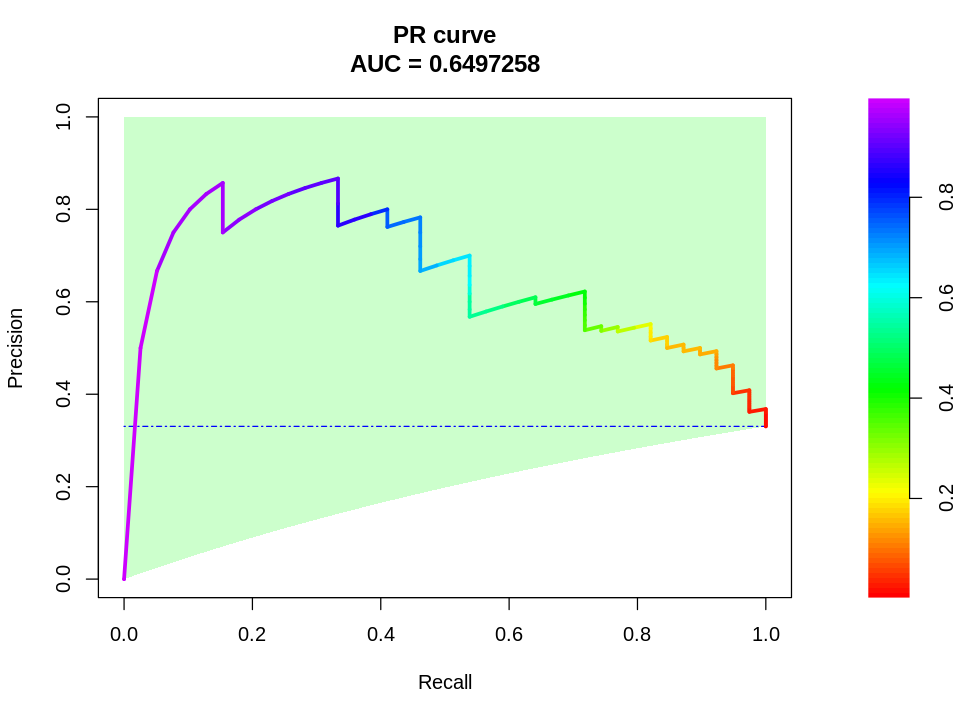

In [53]:
#::GMG::Plot the curve
# https://cran.r-project.org/web/packages/PRROC/PRROC.pdf pp 3-4
plot(pr_curve_full, 
     rand.plot = T,
     fill.area = TRUE, 
     fill.color = rgb(0.8,1,0.8),
     maxminrand.col = "blue"
)

In [54]:
pr_curve_simpler <- PRROC::pr.curve(
                scores.class0 = probabilities_simpler[test_data$diabetes == 'pos'], 
                scores.class1 = probabilities_simpler[test_data$diabetes == 'neg'],
                min.compute = T, 
                max.compute = T,
                rand.compute = T,
                curve = T
)

In [55]:
#::GMG::See all the computed AUCs
print(pr_curve_simpler)


  Precision-recall curve

    Area under curve (Integral):
     0.6749048 

    Relative area under curve (Integral):
     0.6000117 

    Area under curve (Davis & Goadrich):
     0.6746313 

    Relative area under curves (Davis & Goadrich):
     0.5996825 

    Curve for scores from  0.00864713  to  0.9929608 
    ( can be plotted with plot(x) )



    Maximum AUC:
     1   1 


    Minimum AUC:
     0.1872383   0.1872234 


    AUC of a random classifier:
     0.3305085   0.3305085 


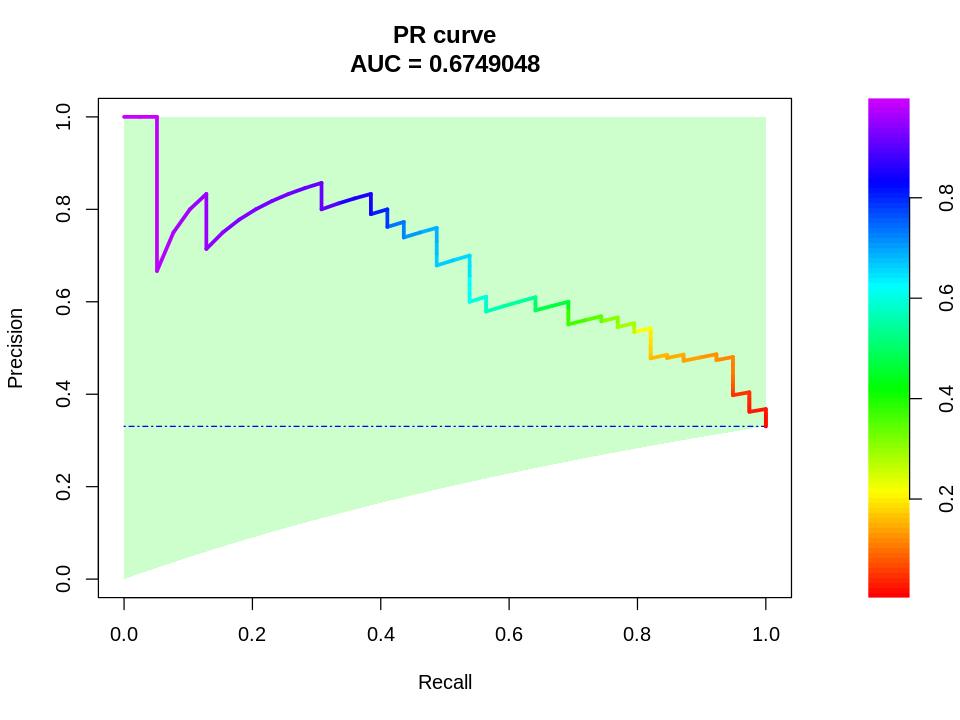

In [56]:
#::GMG::Plot the curve
# https://cran.r-project.org/web/packages/PRROC/PRROC.pdf pp 3-4
plot(pr_curve_simpler, 
     rand.plot = T,
     fill.area = TRUE, 
     fill.color = rgb(0.8,1,0.8),
     maxminrand.col = "blue"
)

### binary classification

In [30]:
#::GMG::Make class predictions (from STHDA)
#predicted_class_full <- ifelse(probabilities_full > 0.5, "pos", "neg")
#::NOTE::I make the result a factor with levels that match the taget variable
#::NOTE::This is claasificatin with the default cut-off ...
predicted_class_full <- as.factor(ifelse(probabilities_full > 0.5, 2, 1))
levels(predicted_class_full) <- c('neg', 'pos')
str(predicted_class_full)

 Factor w/ 2 levels "neg","pos": 1 1 1 1 2 2 1 2 2 1 ...
 - attr(*, "names")= chr [1:118] "7" "19" "26" "28" ...


In [31]:
head(predicted_class_full)

7  19  26  28  29  41 
neg neg neg neg pos pos 
Levels: neg pos

In [34]:
# predicted_class_num <- ifelse(probabilities_full > 0.5, 1, 0)
#::NOTE::I make the result a factor with levels that match the taget variable
#predicted_class_simpler <- ifelse(probabilities_simpler > 0.5, "pos", "neg")
predicted_class_simpler <- as.factor(ifelse(probabilities_simpler > 0.5, 2, 1))
levels(predicted_class_simpler) <- c('neg', 'pos')
str(predicted_class_simpler)

 Factor w/ 2 levels "neg","pos": 1 1 1 1 2 2 1 2 2 1 ...
 - attr(*, "names")= chr [1:118] "7" "19" "26" "28" ...


In [35]:
head(predicted_class_simpler)

7  19  26  28  29  41 
neg neg neg neg pos pos 
Levels: neg pos

### evaluation: confusion matrix and metrics

In [36]:
#::GMG::'Raw' Model accuracy
observed_classes <- test_data$diabetes
str(observed_classes)

 Factor w/ 2 levels "neg","pos": 2 1 2 1 1 1 1 2 2 1 ...


In [37]:
head(observed_classes)

[1] pos neg pos neg neg neg
Levels: neg pos

In [38]:
cat('Accuracy Full Model: ', 
    mean(predicted_class_full == observed_classes),
   '\nAccuracy Simpler Model: ', 
    mean(predicted_class_simpler == observed_classes))

Accuracy Full Model:  0.7288136 
Accuracy Simpler Model:  0.7457627

In [39]:
#::GMG::Confusion Matrix AND metrics
# https://www.rdocumentation.org/packages/base/versions/3.6.1/topics/table
# https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
# https://stackoverflow.com/questions/33621592/sum-of-antidiagonal-of-a-matrix
# https://stackoverflow.com/questions/14577412/how-to-convert-variable-object-name-into-string
confusion_matrix <- function (true, pred, beta = 1) {
    t <- table(true, pred)
    p <- t[2,2]/sum(t[,2])  #::NOTE::I assume 'positive class' is class2 (whatever it is)
    r <- t[2,2]/sum(t[2,])  #::NOTE::I assume 'positive class' is class2 (whatever it is)
    s <- t[1,1]/sum(t[1,])
    list(cm = t,
         accuracy = sum(diag(t))/sum(t), 
         precision = p,     #::NOTE::Precision of 'positive class'    
         recall = r,        #::NOTE::it's also called sensitivity ('positive class again')
         f1 = (1 + beta^2) * p * r/((beta^2 * p) + r),  #::NOTA::beta = 1 -> equal importance (class1, class2)
         specificity = s,   #::NOTE::proportion of actual 'negative class' that are detected as such
         balanced_accuracy = (r + s) / 2
        )
}

In [40]:
#::GMG::Confusion Matrix
cf_full <- confusion_matrix(true = test_data$diabetes, pred = predicted_class_full)
print(cf_full$cm)

     pred
true  neg pos
  neg  63  16
  pos  16  23


In [41]:
#::GMG::Confusion Matrix of the 'simpler' model ... no difference!
cf_simpler <- confusion_matrix(true = test_data$diabetes, pred = predicted_class_simpler)
print(cf_simpler$cm)

     pred
true  neg pos
  neg  63  16
  pos  14  25


In [42]:
#::GMG:Pretty print the model metrics as a table/data frame/...
# https://cran.r-project.org/web/packages/tibble/vignettes/tibble.html
# tibble::tibble(metric = names(cf[-1]), pima_logit = cf[-1])
# https://www.r-bloggers.com/converting-a-list-to-a-data-frame/
#as.data.frame.list(x = cf[-1], row.names = c('pima_logit'))
# https://stackoverflow.com/questions/32059798/list-of-named-lists-to-data-frame
# https://stackoverflow.com/questions/10432993/named-list-to-from-data-frame
# https://www.rdocumentation.org/packages/base/versions/3.6.1/topics/as.data.frame
# https://www.rdocumentation.org/packages/base/versions/3.6.1/topics/names
#::NOTE::sensitivity (pos class) is recall
results <- as.data.frame(t(sapply(list(cf_full[-1], cf_simpler[-1]), rbind)),
                         row.names = c('full_model', 'simpler_model')
)
colnames(results) <- names(cf_full[-1])
# https://stackoverflow.com/questions/23217520/limiting-the-number-of-decimals-in-a-dataframe-r
print(results, digits = 3)

              accuracy precision recall    f1 specificity balanced_accuracy
full_model       0.729      0.59   0.59  0.59       0.797             0.694
simpler_model    0.746      0.61  0.641 0.625       0.797             0.719


**::PENDING::** <span style="color:red">Thresholding here here</span>

## Model with Lasso (L1 regularization)

In [57]:
ls()

[1] "cf_full"                 "cf_simpler"             
 [3] "confusion_matrix"        "full_model"             
 [5] "msk"                     "observed_classes"       
 [7] "pima_clean"              "PimaIndiansDiabetes2"   
 [9] "pr_curve_full"           "pr_curve_simpler"       
[11] "predicted_class_full"    "predicted_class_simpler"
[13] "probabilities_full"      "probabilities_simpler"  
[15] "relevant.x"              "results"                
[17] "sig.formula"             "simpler_model"          
[19] "test_data"               "toselect.x"             
[21] "train_data"              "using"

### features/target split

In [58]:
#::NOTE::The R function model.matrix() helps to create the matrix of predictors and also automatically 
#        converts categorical predictors to appropriate dummy variables, which is required for the glmnet() 
#        function.
# https://www.rdocumentation.org/packages/stats/versions/3.6.1/topics/model.matrix
# Dumy code categorical predictor variables
X_train <- stats::model.matrix(diabetes~., train_data)[,-1]

In [59]:
# Convert the outcome (class) to a numerical variable
y_train <- ifelse(train_data$diabetes == "pos", 1, 0)

In [60]:
#::NOTE::Check the results (a named 2D matrix of features)
str(X_train)

 num [1:274, 1:8] 1 0 2 1 5 0 1 3 11 3 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:274] "4" "5" "9" "14" ...
  ..$ : chr [1:8] "pregnant" "glucose" "pressure" "triceps" ...


In [61]:
#::NOTE::Check the results (a numeric 1/0 vector)
str(y_train)

 num [1:274] 0 1 1 1 1 1 1 0 1 1 ...


In [62]:
#::GMG::Do the same with test, of course
X_test <- model.matrix(diabetes ~., test_data)[,-1]

In [63]:
str(X_test)

 num [1:118, 1:8] 3 1 10 1 13 3 5 8 7 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:118] "7" "19" "26" "28" ...
  ..$ : chr [1:8] "pregnant" "glucose" "pressure" "triceps" ...


In [64]:
y_test <- ifelse(test_data$diabetes == "pos", 1, 0)

In [65]:
str(y_test)

 num [1:118] 1 0 1 0 0 0 0 1 1 0 ...


### computing best lambda with cv

In [66]:
#::GMG::Make it reproducible
#::NOTE::Not sure if necessary but CV in involved ...
set.seed(123) 

In [67]:
#::GMG::In penalized regression, you need to specify a constant lambda to adjust the amount of 
#       the coefficient shrinkage. The best lambda for your data, can be defined as the lambda 
#       that minimize the cross-validation prediction error rate. This can be determined automatically 
#       using the function cv.glmnet()
# https://www.rdocumentation.org/packages/glmnet/versions/2.0-18/topics/cv.glmnet
#::NOTE::compute lasso regression by specifying the option alpha = 1
# Find the optimal value of lambda that minimizes the cross-validation error:
cv_lasso <- glmnet::cv.glmnet(x = X_train, 
                              y = y_train, 
                              alpha = 1,
                              type.measure = 'class', #::NOTE::misclassification error
                              family = 'binomial')

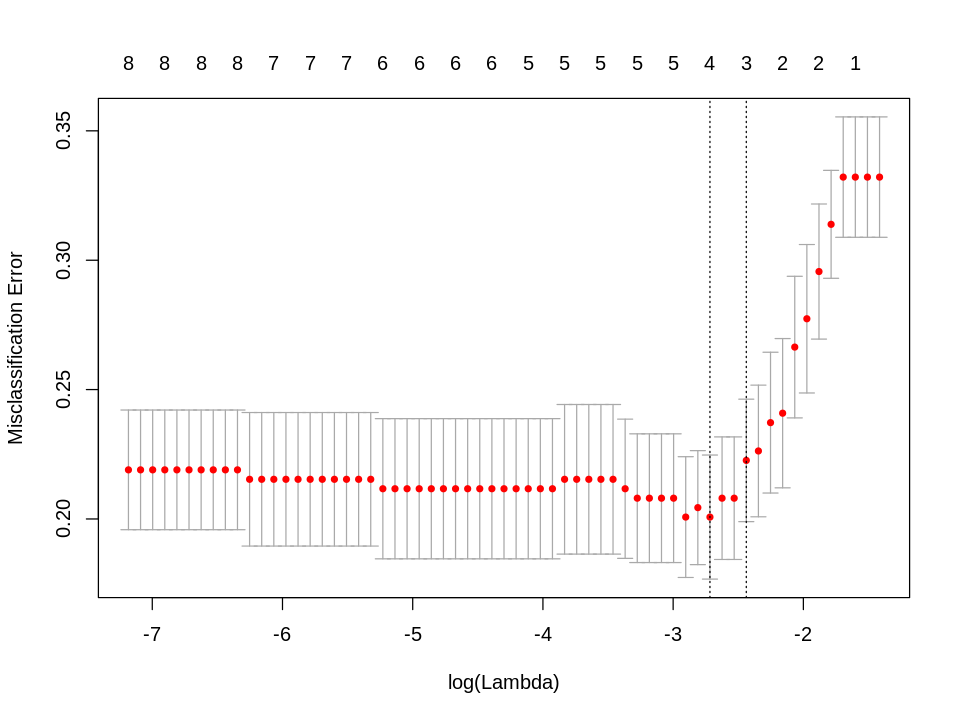

In [68]:
#::GMG::See graphically the best lambda
plot(cv_lasso)

The plot displays the cross-validation *misclassification error* according to the log of lambda. The *left dashed vertical line* indicates that the log of the optimal value of lambda `lambda.min` is approximately -3, which is the one that minimizes the prediction error. This lambda value will give the most accurate model. The exact value of lambda can be viewed as follow:

In [69]:
cat('Optimum lambda: ', cv_lasso$lambda.min)

Optimum lambda:  0.0660483

Generally, the purpose of regularization is to balance accuracy and simplicity. This means, a model with the smallest number of predictors that also gives a good accuracy. To this end, the function `cv.glmnet()` finds also the value of lambda that gives the simplest model but also lies within one standard error of the optimal value of lambda. This value is called `lambda.1se`.

In [70]:
cat('Simplest model within one sd of lambda optimum: ', cv_lasso$lambda.1se)

Simplest model within one sd of lambda optimum:  0.08731196

### shrinked coefficients

Using lambda.min as the best lambda, gives the following regression coefficients:

In [71]:
# https://www.rdocumentation.org/packages/stats/versions/3.6.1/topics/coef (?)
stats::coef(cv_lasso, cv_lasso$lambda.min)

9 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept) -6.01175423
pregnant     .         
glucose      0.02358263
pressure     .         
triceps      .         
insulin      .         
mass         0.02949961
pedigree     0.04111407
age          0.04315104

In [72]:
#::NOTE:the "native" glmnet packaage coef() (same result)
glmnet::coef.cv.glmnet(cv_lasso, cv_lasso$lambda.min)

9 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept) -6.01175423
pregnant     .         
glucose      0.02358263
pressure     .         
triceps      .         
insulin      .         
mass         0.02949961
pedigree     0.04111407
age          0.04315104

Using `lambda.1se` as the best lambda, gives the following regression coefficients:

In [73]:
coef(cv_lasso, cv_lasso$lambda.1se)

9 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept) -4.85014301
pregnant     .         
glucose      0.02070629
pressure     .         
triceps      .         
insulin      .         
mass         0.01526296
pedigree     .         
age          0.03382121

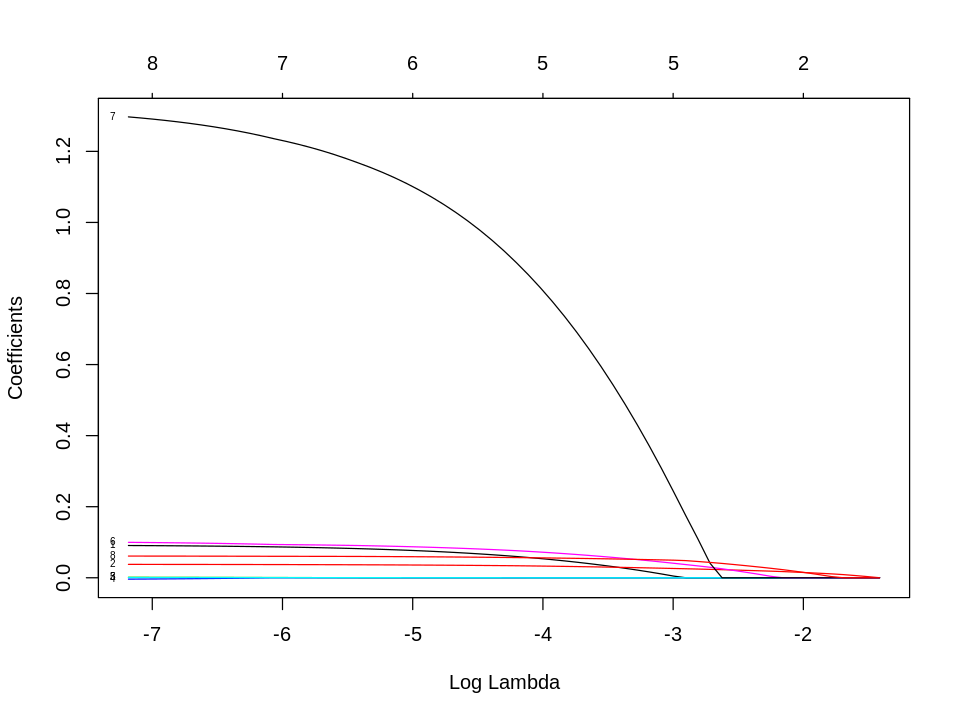

In [74]:
#::GMG::Plot the shrinkage of the coefficients
# https://stackoverflow.com/questions/36656752/plotting-cv-glmnet-in-r~
#::NOTE::How do I put the feature names on that plot?
# https://stats.stackexchange.com/questions/133873/lasso-plot-label-lines-with-names-using-glmnet
# https://www.rdocumentation.org/packages/glmnet/versions/2.0-18/topics/plot.glmnet
plot(cv_lasso$glmnet.fit, "lambda", label = TRUE)

**::PENDING::** <span style="color:red">Discussion here</span>

### better coeff shrinkage plot

In [ ]:
#::GMG::Adhoc function intermediate fix
#::NOTE::Adapted from
# https://stackoverflow.com/a/43327018
lbs_fun <- function(lra, ...) {
  fit <- lra$glmnet.fit

  L=which(fit$lambda==lra$lambda.min)

  ystart <- sort(fit$beta[abs(fit$beta[,L])>0,L])
  labs <- names(ystart)
  #::NOTE:: max gap between biggest and smallest coefs at smallest lambda
  #         i.e., 64th (more than that yields an error ... given 100th lambda
  #         in original!)
  r <- range(fit$beta[,64]) 
  yfin <- seq(r[1],r[2],length=length(ystart))

  xstart<- log(lra$lambda.min)
  xfin <- xstart+1

  text(xfin+0.3,yfin,labels=labs,...)
  segments(xstart,ystart,xfin,yfin)
  # https://www.r-bloggers.com/r-add-vertical-line-to-a-plot/
  # https://www.statmethods.net/advgraphs/parameters.html
  abline(v = log(lra$lambda.min), col = 'darkgreen', lty = 3, lwd = 2) 
  text(log(lra$lambda.min) - 1, r[2], col = 'darkgreen', 'chosen lambda')
  segments(log(lra$lambda.min), r[2] - 0.3 , log(lra$lambda.min) - 1, r[2], col = 'darkgreen')
}

In [ ]:
#::GMG::Let's what it looks like ...
options(repr.plot.width = 8, repr.plot.height = 6)
plot(cv_lasso$glmnet.fit, label=FALSE, xvar="lambda")
lbs_fun(cv_lasso)

### better coeff shrinkage plot with plotmo

In [ ]:
#::GMG::It's weird with those numeric labels (plot.glmnet)ç
#::NOTE::It seems there's an alternative with adhoc plotmo package
# https://stackoverflow.com/questions/30560689/adding-labels-on-curves-in-glmnet-plot-in-r
# https://stats.stackexchange.com/questions/133873/lasso-plot-label-lines-with-names-using-glmnet
# https://cran.r-project.org/web/packages/plotmo/plotmo.pdf#page=17
# plot_glmnet: Plot a glmnet model (Plot the coefficient paths of a glmnet model.)
# http://www.milbo.org/doc/plotres-notes.pdf#page=7
options(repr.plot.width = 8, repr.plot.height = 6)
plotmo::plot_glmnet(x = cv_lasso$glmnet.fit, xvar = 'lambda', label = TRUE)

### model

**::GMG::** In STHDA a new model is trained with the best lambdas found out with the CV approach. Is it really necessary to do that? Does not `cv.glmnet()` already have provided such a model?

In [ ]:
#::GMG::Cross-validated model with ... lambda.min or lambda.1se?
# https://www.rdocumentation.org/packages/glmnet/versions/2.0-18/topics/cv.glmnet
# https://cran.r-project.org/web/packages/glmnet/glmnet.pdf pp. 6, 
# glmnet.fit: a fitted glmnet object for the full data.
str(cv_lasso$glmnet.fit)

In [ ]:
#::GMG::Let's see the regression coefficients
coef(cv_lasso)

In [ ]:
#::GMG:: (STHDA) Fit the final model on the training data and lambda.min
model_lambda_min <- glmnet(
    X_train, 
    y_train, 
    alpha = 1,                     #::NOTE:: L1 LASSO regularization
    family = "binomial",
    lambda = cv_lasso$lambda.min   #::NOTE::Lambda min for L1
)

In [ ]:
# Display regression coefficients
coef(model_lambda_min)

In [ ]:
#::GMG::Final model with lambda.1se (this is the only way to get it this time)
model_lambda_1se <- glmnet(
    X_train, 
    y_train, 
    alpha = 1, 
    family = "binomial",
    lambda = cv_lasso$lambda.1se
)

In [ ]:
# Display regression coefficients
coef(model_lambda_1se)

**::GMG::** Looking at the `coef()` from `cv_lasso` and `model_lambda_1se` I conclude that the model returned as value (`cv_lasso$glmnet.fit` reported in the documentation) is the simpler regularized L1 model indeed! 

### predict

In [ ]:
#::GMG::Make predictions on the test data using the new trained model (STHDA)
probabilities_lambda_min <- predict(model_lambda_min, newx = X_test)
predicted_classes_lambda_min <- ifelse(probabilities_lambda_min > 0.5, "pos", "neg")
#::NOTE::For the P/R Curve function
predicted_classes_lambda_min_num <- ifelse(probabilities_lambda_min > 0.5, 1, 0)

In [ ]:
#::GMG::Make prediction on test data on the test data using the lambda 1se model
probabilities_1se <- predict(model_lambda_1se, newx = X_test)
predicted_classes_1se <- ifelse(probabilities_1se > 0.5, "pos", "neg")
predicted_classes_1se_num <- ifelse(probabilities_1se > 0.5, 1, 0)

In [ ]:
#::GMG::Predict using the cross-validated model
# https://cran.r-project.org/web/packages/glmnet/glmnet.pdf pp. 18
# https://www.rdocumentation.org/packages/glmnet/versions/2.0-18/topics/predict.cv.glmnet
# This function makes predictions from a cross-validated glmnet model, using the stored "glmnet.fit" object, 
# and the optimal value chosen for lambda.
#::NOTE::So as long as I don't want the simpler model with lambda.1se I can predict with this!
probabilities_cv_lasso <- predict(cv_lasso, newx = X_test)
predicted_classes_cv_lasso <- ifelse(probabilities_cv_lasso > 0.5, "pos", "neg")
#::NOTE::For the P/R Curve function
predicted_classes_cv_lasso_num <- ifelse(probabilities_cv_lasso > 0.5, 1, 0)

In [ ]:
probabilities_lambda_min

### evaluation: confusion matrix and metrics

In [ ]:
#::GMG::'Raw' Model accuracy
#::NOTE::observed_classes <- test_data$diabetes
cat('Accuracy L1 Lambda Min Model: ', 
    mean(predicted_classes_lambda_min == observed_classes),
   '\nAccuracy L1 Lambda 1se (Simpler) Model: ', 
    mean(predicted_classes_1se == observed_classes),
   '\nAccuracy CV Lasso Model: ', 
    mean(predicted_classes_cv_lasso == observed_classes)
)

In [ ]:
#::GMG::Confusion Matrix
cf_lambda_min <- confusion_matrix(true = test_data$diabetes, pred = predicted_classes_lambda_min)
#cf_lambda_min <- MLmetrics::ConfusionMatrix(y_true = test_data$diabetes, 
#                                            y_pred = predicted_classes_lambda_min)
#print(cf_lambda_min)
print(cf_lambda_min$cm)

In [ ]:
#::GMG::Confusion Matrix
cf_lambda_1se <- confusion_matrix(true = test_data$diabetes, pred = predicted_classes_1se)
print(cf_lambda_1se$cm)

In [ ]:
#::GMG::Confusion Matrix
cf_cv_lasso <- confusion_matrix(true = test_data$diabetes, pred = predicted_classes_cv_lasso)
print(cf_cv_lasso$cm)

In [ ]:
#::GMG::Metrics
# https://stackoverflow.com/questions/3443687/formatting-decimal-places-in-r
cat(sep='', "Accuracy: ", format(round(cf_full$accuracy, 2), nsmall = 2), 
    ", Balanced Accuracy ", format(round(cf_full$balanced_accuracy, 2), nsmall = 2))

In [ ]:
cat(sep = '', "Precision: ", format(round(cf_full$precision, 2), nsmall = 2), 
    ", Recall: ", format(round(cf_full$recall, 2), nsmall = 2),
    ", Fl: ", format(round(cf_full$f1, 2), nsmall = 2)
   )

In [ ]:
cat(sep='', "Specificity: ", format(round(cf_full$specificity, 2), nsmall = 2), 
    ", Sensitivity ", format(round(cf_full$recall, 2), nsmall = 2))

In [ ]:
#::GMG::Confusion Matrix of the 'simpler' model ... no difference!
cf_simpler <- confusion_matrix(true = test_data$diabetes, pred = predicted_class_simpler)
print(cf_simpler$cm)

### evaluation: P/R Curve

In [ ]:
#::GMG::Compute the curve
# https://cran.r-project.org/web/packages/PRROC/PRROC.pdf pp. 7
# Soft-labeled classification problems:
# Each data point belongs to both of the two classes with a certain probability, where for each datapoint, these 
# two probabilities add up to 1.  In this case, the classification scores for all data points need to be provided 
# only once as scores.class0 and only the positive/foreground weights for each data point need to be provided in
# weights.class0, while the converse probability for the negative class is automatically set to 
# weights.class1 = 1.0 - weights.class0.
pr_curve_full <- PRROC::pr.curve(
                scores.class0 = predicted_class_num, 
                weights.class0 = probabilities_full,
                min.compute = T, 
                max.compute = T,
                rand.compute = T,
                curve = T
)

In [ ]:
#::GMG::See all things within the pr_1 object
print(pr_curve_full)

In [ ]:
#::GMG::Plot the curve
# https://cran.r-project.org/web/packages/PRROC/PRROC.pdf pp 3-4
options(repr.plot.width = 8, repr.plot.height = 6)
plot(pr_curve_full, rand.plot = T)

**::PENDING::** <span style="color:red">Discussion here</span>

**::NOTE::** Is this right?

In [ ]:
ls()